###YOLO-Object-Detection
CNN-based Object Detectors are primarily applicable for recommendation systems. YOLO (You Only Look Once) models are used for Object detection with high performance. YOLO divides an image into a grid system, and each grid detects objects within itself. They can be used for real-time object detection based on the data streams. They require very few computational resources.

###Dataset

The COCO 2017 Dataset (Common Objects in Context) is a widely recognized benchmark in computer vision, designed for tasks such as object detection, instance segmentation, and keypoint detection. It encompasses 80 object categories representing everyday scenes and provides approximately 118,000 training images, 5,000 validation images, and 41,000 test images. The dataset includes detailed annotations for training and validation, such as bounding boxes, segmentation masks, and keypoints, making it an essential resource for general-purpose object detection and comprehensive model evaluation. To reduce the training time, We have created a subset consisting of 773 training images, 180 validation images, and 184 test images.

#### Download Dataset

In [ ]:
#!mkdir coco
#!cd coco
#!mkdir images
#!cd images
#
#!wget http://images.cocodataset.org/zips/train2017.zip
#!wget http://images.cocodataset.org/zips/val2017.zip
#!wget http://images.cocodataset.org/zips/test2017.zip
#!wget http://images.cocodataset.org/zips/unlabeled2017.zip
#
#!unzip train2017.zip
#!unzip val2017.zip
#!unzip test2017.zip
#!unzip unlabeled2017.zip
#
#!rm train2017.zip
#!rm val2017.zip
#!rm test2017.zip
#!rm unlabeled2017.zip

#!cd ../
#!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
#!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
#!wget http://images.cocodataset.org/annotations/image_info_test2017.zip
#!wget http://images.cocodataset.org/annotations/image_info_unlabeled2017.zip
#
#!unzip annotations_trainval2017.zip
#!unzip stuff_annotations_trainval2017.zip
#!unzip image_info_test2017.zip
#!unzip image_info_unlabeled2017.zip
#
#!rm annotations_trainval2017.zip
#!rm stuff_annotations_trainval2017.zip
#!rm image_info_test2017.zip
#!rm image_info_unlabeled2017.zip


####Annotate Dataset

To train the model we need to annotate the data according to YOLO Format and store in below floder staructure


In [ ]:
#dataset/
#├── images/
#│   ├── train/
#│   ├── val/
#│   ├── test/
#├── labels/
#│   ├── train/
#│   ├── val/
#│   ├── test/

In [ ]:
import json
import os
from pathlib import Path

def coco_to_yolo(coco_annotation_path, output_dir, image_dir):
    # Load COCO annotation JSON
    with open(coco_annotation_path, 'r') as f:
        coco_data = json.load(f)

    # Create output directory for labels
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Map category IDs to zero-based IDs
    category_map = {cat['id']: idx for idx, cat in enumerate(coco_data['categories'])}

    # Iterate through images and annotations
    for image_info in coco_data['images']:
        image_id = image_info['id']
        image_width = image_info['width']
        image_height = image_info['height']
        image_filename = image_info['file_name']

        # Open corresponding annotation file
        annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

        # Create a YOLO annotation file for each image
        label_path = os.path.join(output_dir, f"{Path(image_filename).stem}.txt")
        with open(label_path, 'w') as label_file:
            for ann in annotations:
                category_id = ann['category_id']
                bbox = ann['bbox']  # COCO format: [x_min, y_min, width, height]

                # Convert COCO bbox to YOLO format
                x_min, y_min, width, height = bbox
                x_center = x_min + width / 2
                y_center = y_min + height / 2

                # Normalize coordinates
                x_center /= image_width
                y_center /= image_height
                width /= image_width
                height /= image_height

                # Write to file
                label_file.write(f"{category_map[category_id]} {x_center} {y_center} {width} {height}\n")

    print(f"YOLO annotations saved in {output_dir}")

# Paths
coco_annotation_path = "/content/drive/MyDrive/Deep-Learning-project/coco/annotations/instances_train2017.json"
output_dir = "/content/drive/MyDrive/Deep-Learning-project/coco/output/labels"
image_dir = "/content/drive/MyDrive/Deep-Learning-project/coco/images/train2017"  # Folder with train images

# Convert
coco_to_yolo(coco_annotation_path, output_dir, image_dir)

#### Create Subset

In [ ]:
import os
import shutil
import random
from collections import defaultdict

# Paths to your dataset
base_dir = "/content/drive/MyDrive/Deep-Learning-project/full-dataset"
output_base_dir = "/content/drive/MyDrive/Deep-Learning-project/dataset"
os.makedirs(output_base_dir, exist_ok=True)

splits = {
    "train": {"input_images": os.path.join(base_dir, "images/train"),
              "input_labels": os.path.join(base_dir, "labels/train"),
              "output_images": os.path.join(output_base_dir, "images/train"),
              "output_labels": os.path.join(output_base_dir, "labels/train"),
              "size": 1000},
    "val": {"input_images": os.path.join(base_dir, "images/val"),
            "input_labels": os.path.join(base_dir, "labels/val"),
            "output_images": os.path.join(output_base_dir, "images/val"),
            "output_labels": os.path.join(output_base_dir, "labels/val"),
            "size": 250},
    "test": {"input_images": os.path.join(base_dir, "images/test"),
             "input_labels": os.path.join(base_dir, "labels/test"),
             "output_images": os.path.join(output_base_dir, "images/test"),
             "output_labels": os.path.join(output_base_dir, "labels/test"),
             "size": 250},
}

# Create subset directories
for split, paths in splits.items():
    os.makedirs(paths["output_images"], exist_ok=True)
    os.makedirs(paths["output_labels"], exist_ok=True)

# Function to ensure class balance
def create_subset(input_images_dir, input_labels_dir, output_images_dir, output_labels_dir, subset_size):
    # Map classes to images
    class_to_images = defaultdict(list)

    # Parse all label files and group images by class
    for label_file in os.listdir(input_labels_dir):
        if label_file.endswith(".txt"):
            with open(os.path.join(input_labels_dir, label_file), 'r') as f:
                for line in f:
                    class_id = line.split()[0]
                    image_name = os.path.splitext(label_file)[0] + ".jpg"
                    class_to_images[class_id].append(image_name)

    # Shuffle each class's images
    for class_id in class_to_images:
        random.shuffle(class_to_images[class_id])

    # Select a balanced subset
    selected_images = set()
    total_classes = len(class_to_images)
    images_per_class = subset_size // total_classes

    for class_id, images in class_to_images.items():
        selected_images.update(images[:images_per_class])

    # Copy selected images and corresponding labels
    for image_file in selected_images:
        # Copy image
        shutil.copy(os.path.join(input_images_dir, image_file), os.path.join(output_images_dir, image_file))
        # Copy corresponding label
        label_file = os.path.splitext(image_file)[0] + ".txt"
        shutil.copy(os.path.join(input_labels_dir, label_file), os.path.join(output_labels_dir, label_file))

    print(f"Subset created: {len(selected_images)} images for {output_images_dir}")
    return len(selected_images)

# Create subsets for train, val, and test
for split, paths in splits.items():
    create_subset(paths["input_images"], paths["input_labels"], paths["output_images"], paths["output_labels"], paths["size"])

#### Explore Dataset

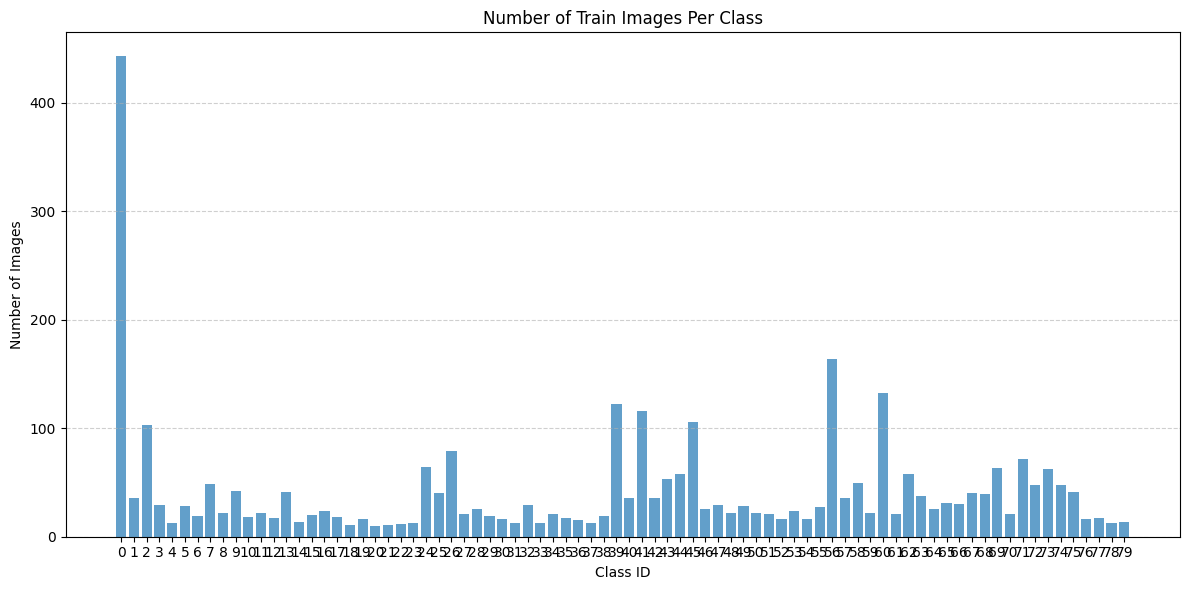

In [ ]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

# Path to the labels directory
labels_dir = "/content/drive/MyDrive/deep-learning-project/dataset/labels/train"

# Dictionary to map class IDs to a set of image filenames
class_to_images = defaultdict(set)

# Iterate over all label files in the directory
for label_file in os.listdir(labels_dir):
    if label_file.endswith(".txt"):
        label_file_path = os.path.join(labels_dir, label_file)

        # Open and read each label file
        with open(label_file_path, 'r') as file:
            for line in file:
                # Extract the class ID (first element in each line)
                class_id = int(line.split()[0])

                # Add the image filename (without extension) to the class
                image_name = os.path.splitext(label_file)[0]
                class_to_images[class_id].add(image_name)

# Prepare data for plotting
classes = sorted(class_to_images.keys())
image_counts = [len(class_to_images[class_id]) for class_id in classes]

# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(classes, image_counts, alpha=0.7)
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.title("Number of Train Images Per Class")
plt.xticks(classes)  # Show all class IDs on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

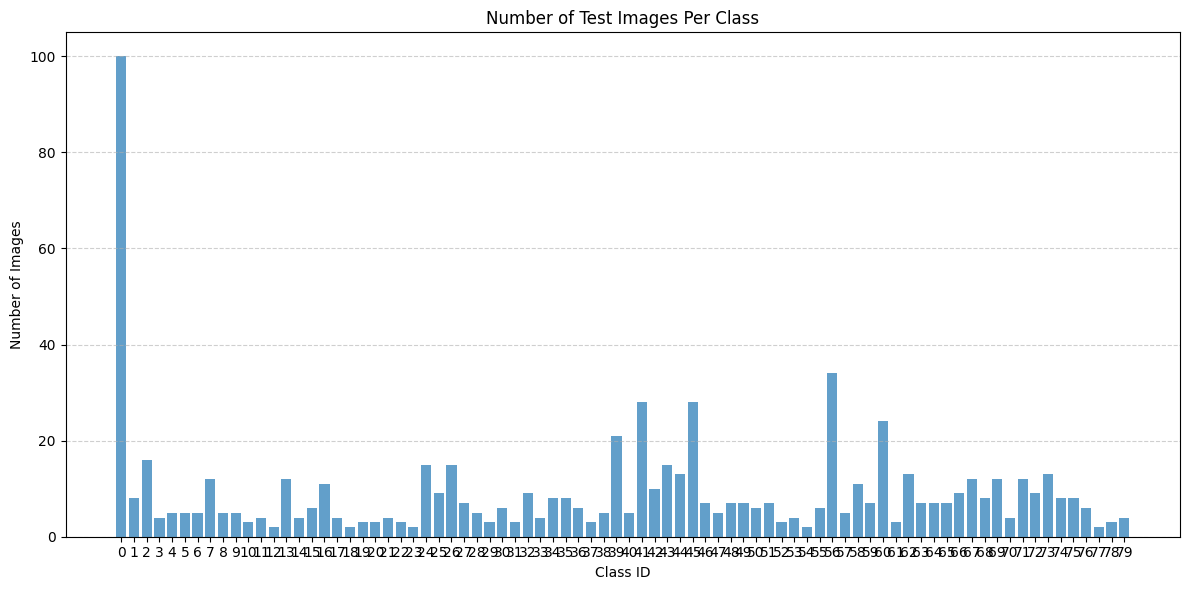

In [ ]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

# Path to the labels directory
labels_dir = "/content/drive/MyDrive/deep-learning-project/dataset/labels/test"

# Dictionary to map class IDs to a set of image filenames
class_to_images = defaultdict(set)

# Iterate over all label files in the directory
for label_file in os.listdir(labels_dir):
    if label_file.endswith(".txt"):
        label_file_path = os.path.join(labels_dir, label_file)

        # Open and read each label file
        with open(label_file_path, 'r') as file:
            for line in file:
                # Extract the class ID (first element in each line)
                class_id = int(line.split()[0])

                # Add the image filename (without extension) to the class
                image_name = os.path.splitext(label_file)[0]
                class_to_images[class_id].add(image_name)

# Prepare data for plotting
classes = sorted(class_to_images.keys())
image_counts = [len(class_to_images[class_id]) for class_id in classes]

# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(classes, image_counts, alpha=0.7)
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.title("Number of Test Images Per Class")
plt.xticks(classes)  # Show all class IDs on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

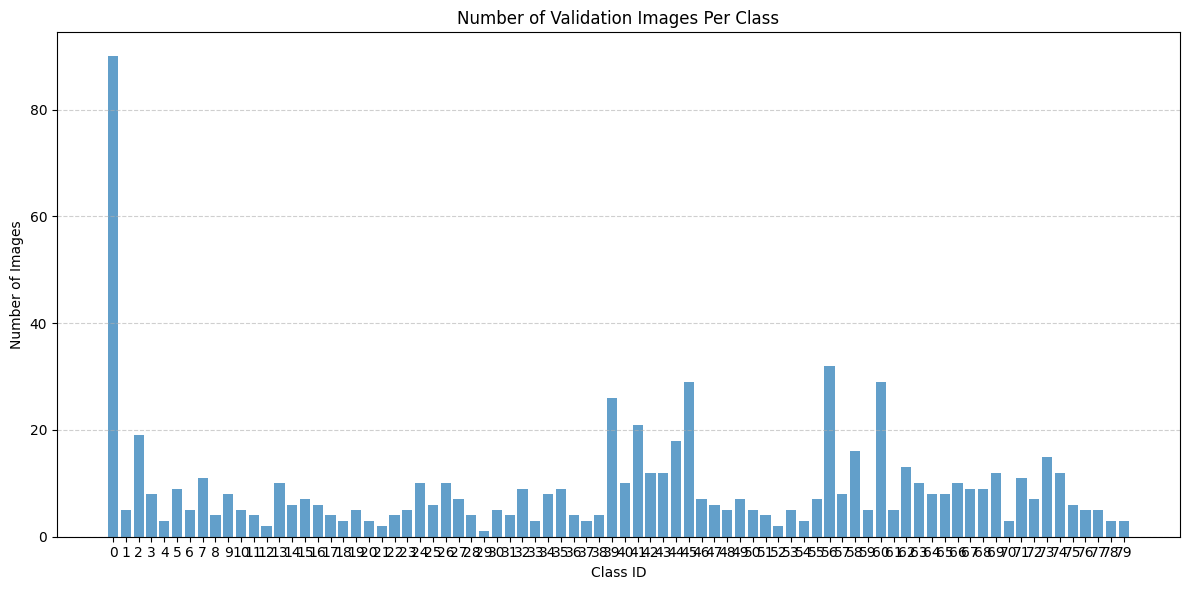

In [ ]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

# Path to the labels directory
labels_dir = "/content/drive/MyDrive/deep-learning-project/dataset/labels/val"

# Dictionary to map class IDs to a set of image filenames
class_to_images = defaultdict(set)

# Iterate over all label files in the directory
for label_file in os.listdir(labels_dir):
    if label_file.endswith(".txt"):
        label_file_path = os.path.join(labels_dir, label_file)

        # Open and read each label file
        with open(label_file_path, 'r') as file:
            for line in file:
                # Extract the class ID (first element in each line)
                class_id = int(line.split()[0])

                # Add the image filename (without extension) to the class
                image_name = os.path.splitext(label_file)[0]
                class_to_images[class_id].add(image_name)

# Prepare data for plotting
classes = sorted(class_to_images.keys())
image_counts = [len(class_to_images[class_id]) for class_id in classes]

# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(classes, image_counts, alpha=0.7)
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.title("Number of Validation Images Per Class")
plt.xticks(classes)  # Show all class IDs on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

####Train Samples

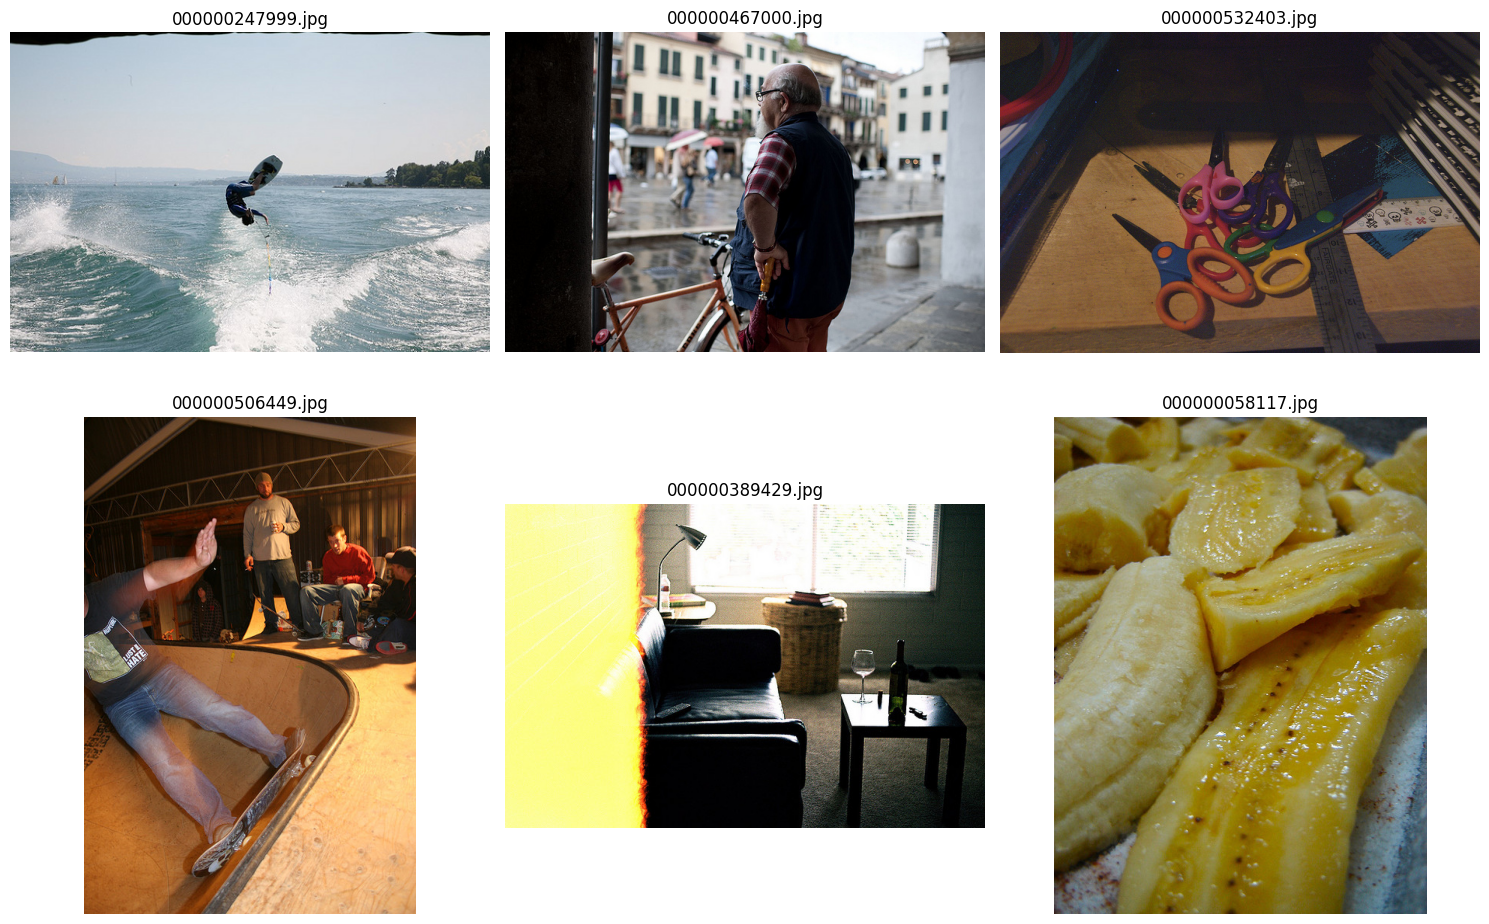

In [ ]:
import os
from PIL import Image

# Path to the train images directory
train_images_dir = "/content/drive/MyDrive/deep-learning-project/dataset/images/train"

# List all image files in the directory
image_files = [f for f in os.listdir(train_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Select the first 6 images (or random 6 if you prefer)
selected_images = image_files[:6]

# Display the images
plt.figure(figsize=(15, 10))
for i, image_file in enumerate(selected_images):
    img_path = os.path.join(train_images_dir, image_file)
    img = Image.open(img_path)

    # Add subplot for each image
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(image_file)  # Display filename as title

plt.tight_layout()
plt.show()

#### Clone and Download YOLOV5 from Ultralytics github

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17059, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 17059 (delta 18), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17059/17059), 15.68 MiB | 11.89 MiB/s, done.
Resolving deltas: 100% (11708/11708), done.


####Install Requirements

In [ ]:
!pip install -r /content/yolov5/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 46.3 MB/s eta 0:00:00


In [ ]:
%cd /content/yolov5

/content/yolov5


#### Connect to Colab Tesla T4 GPU

In [ ]:
!nvidia-smi

Fri Nov 22 23:27:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Train Model

In [ ]:
!python train.py \
  --data /content/drive/MyDrive/deep-learning-project/dataset/coco.yaml \
  --weights yolov5s.pt \
  --img 640 \
  --batch 16 \
  --epochs 10 \
  --device 0


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-22 18:06:13.835166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 18:06:13.855331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 18:06:13.861625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

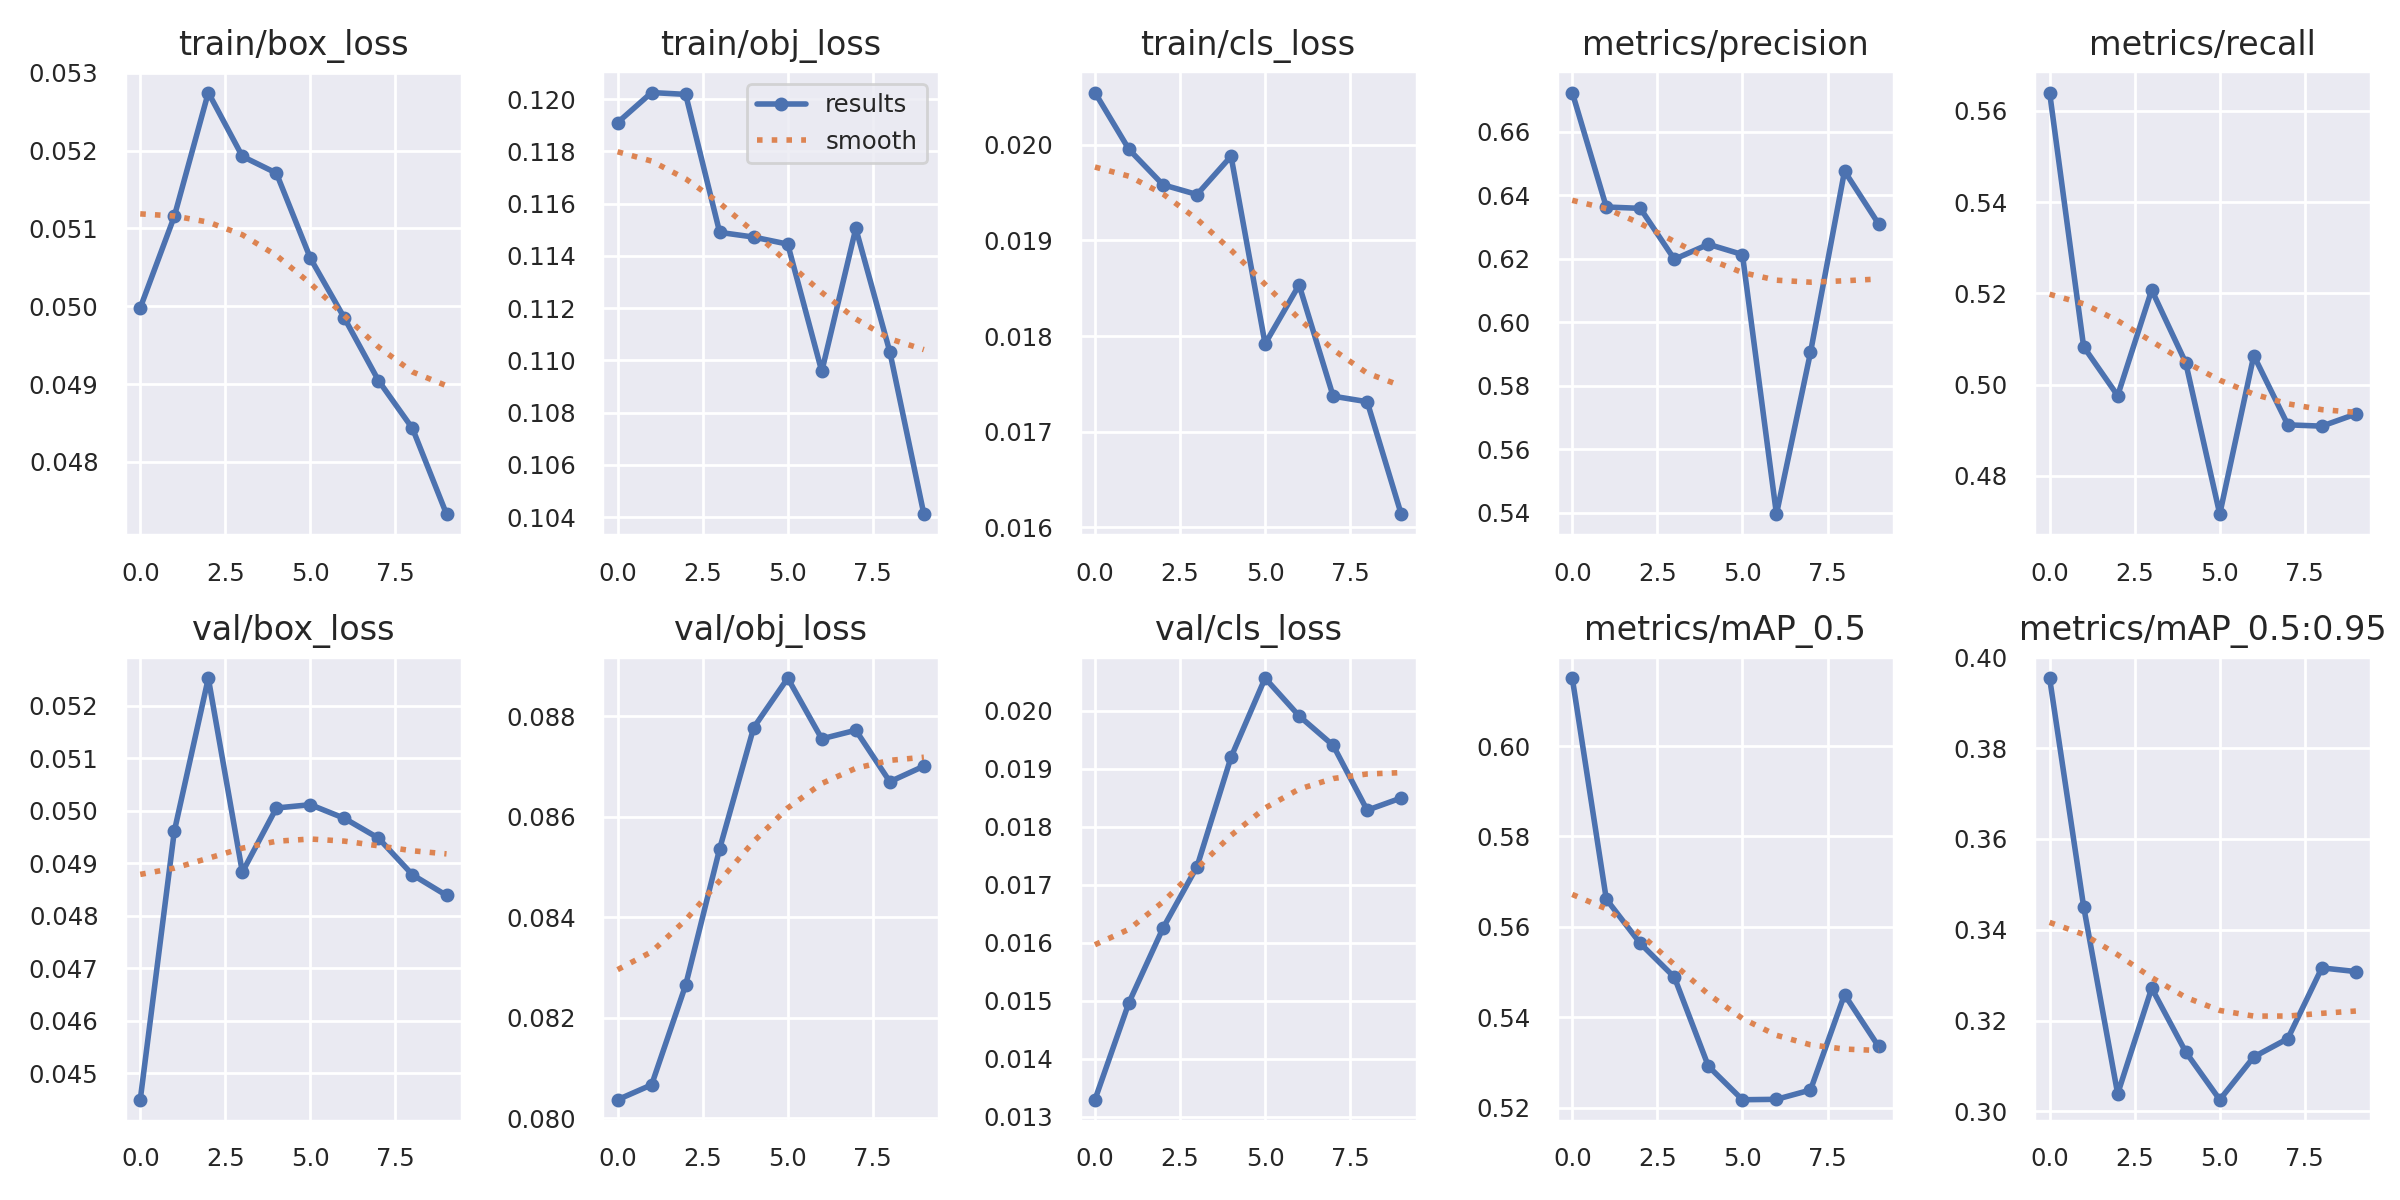

In [12]:
from IPython.display import Image, display

# Path to the image
image_path = "/content/drive/MyDrive/deep-learning-project/yolov5/runs/train/exp/results.png"

# Display the image
display(Image(filename=image_path))

####Validate Model

In [ ]:
!python val.py \
  --data /content/drive/MyDrive/deep-learning-project/dataset/coco.yaml \
  --weights /content/yolov5/runs/train/exp/weights/best.pt \
  --img 640 \
  --task test

val: data=/content/drive/MyDrive/deep-learning-project/dataset/coco.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-386-g81ac034a Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
test: Scanning /content/drive/MyDrive/deep-learning-project/dataset/labels/test... 180 images, 0 backgrounds, 0 corrupt: 100% 180/180 [02:29<00:00,  1.20it/s]
test: New cache created: /content/drive/MyDrive/deep-learning-project/dataset/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 6/6 [00:08<00:00,  1.36s/it]
                   all

#### Test Model

In [ ]:
!python detect.py \
  --weights /content/yolov5/runs/train/exp/weights/best.pt \
  --source /content/drive/MyDrive/deep-learning-project/dataset/images/test \
  --img 640 \
  --conf 0.25 \
  --save-txt \
  --save-conf

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/deep-learning-project/dataset/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-386-g81ac034a Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/180 /content/drive/MyDrive/deep-learning-project/dataset/images/test/000000007899.jpg: 448x640 13 persons, 19 kites, 30.6ms
image 2/180 /content/drive/MyDrive/deep-learning-project/dataset/images/test/0000

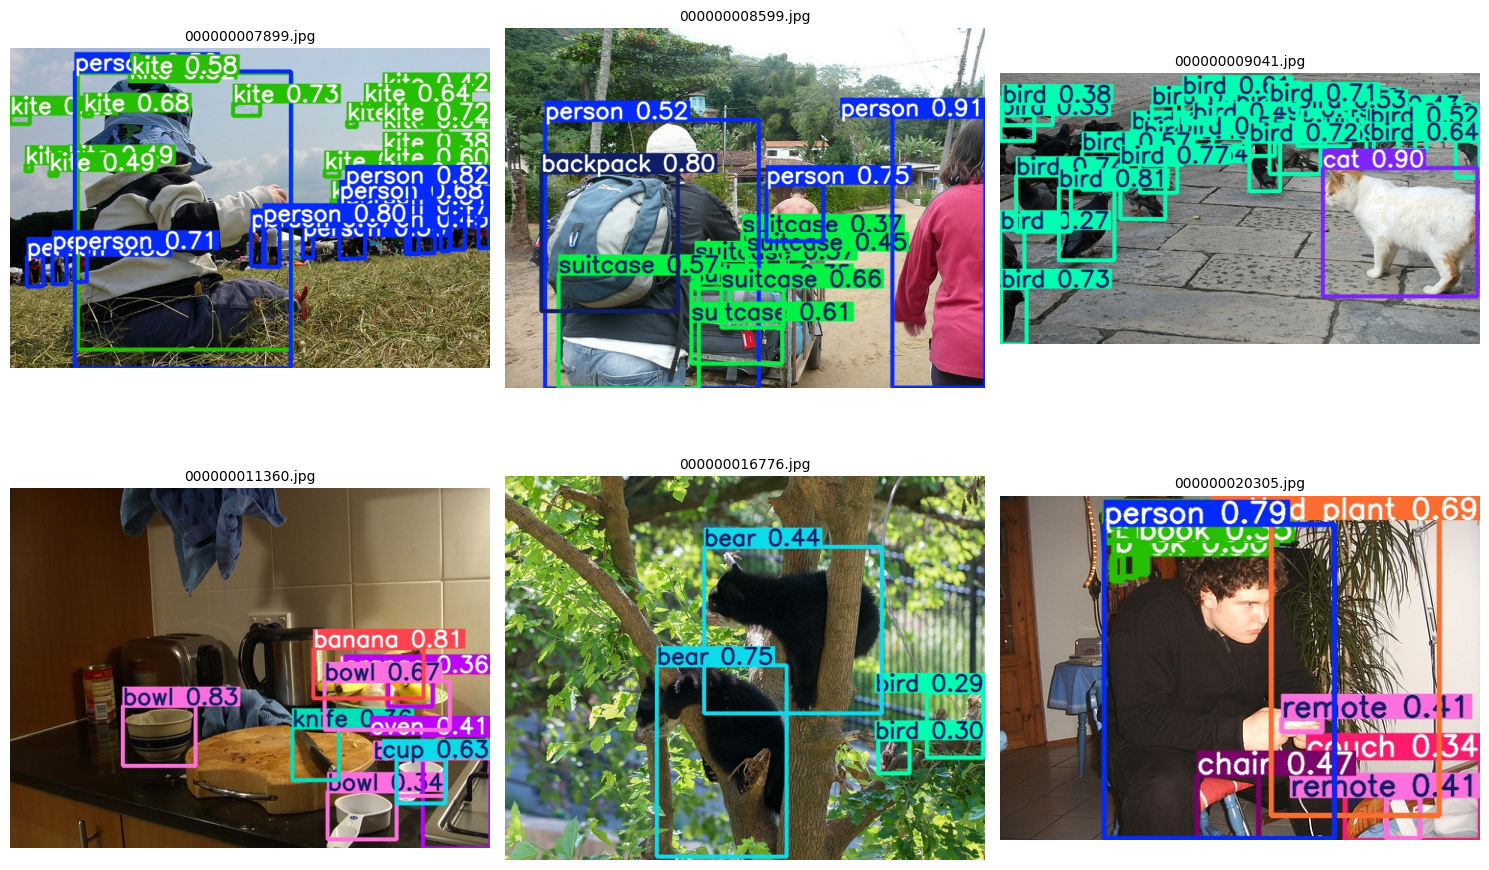

In [ ]:
import os
import matplotlib.pyplot as plt
# Path to the directory containing the images
image_dir = "/content/drive/MyDrive/deep-learning-project/yolov5/runs/detect/exp"

# List all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Select the first 6 images (or fewer if there aren't 6)
selected_images = image_files[:6]

# Display the images
plt.figure(figsize=(15, 10))  # Set the figure size
for i, image_file in enumerate(selected_images):
    img_path = os.path.join(image_dir, image_file)
    img = Image.open(img_path)

    # Add subplot for each image
    plt.subplot(2, 3, i + 1)  # Create a 2x3 grid
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(image_file, fontsize=10)  # Display filename as title

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

In [ ]:
!python detect.py \
  --weights /content/yolov5/runs/train/exp/weights/best.pt \
  --source /content/2.mp4 \
  --img 640 \
  --conf 0.25 \
  --save-txt \
  --save-conf

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/2.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-386-g81ac034a Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
video 1/1 (1/341) /content/2.mp4: 384x640 38 persons, 36.1ms
video 1/1 (2/341) /content/2.mp4: 384x640 35 persons, 1 umbrella, 8.0ms
video 1/1 (3/341) /content/2.mp4: 384x640 34 persons, 1 umbrella, 9.9ms
video 1/1 (4/341) /content/2.mp4: 384x640 35 persons, 1 um